In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from scipy import stats
import statsmodels.api as sm
import csv
import glob

In [4]:
df = pd.read_csv('CSVFiles/all_data_with_identities_50000.csv')

df = df.loc[:, ["comment_text", "split", "toxicity", "male", "female", "LGBTQ", "christian", "muslim", "other_religions", "black", "white"]]
df = df[df['split'] == 'test']

df['male'] = df['male'].apply(lambda x: np.round(x>=0.5))
df['female'] = df['female'].apply(lambda x: np.round(x>=0.5))
df['LGBTQ'] = df['LGBTQ'].apply(lambda x: np.round(x>=0.5))
df['christian'] = df['christian'].apply(lambda x: np.round(x>=0.5))
df['muslim'] = df['muslim'].apply(lambda x: np.round(x>=0.5))
df['other_religions'] = df['other_religions'].apply(lambda x: np.round(x>=0.5))
df['black'] = df['black'].apply(lambda x: np.round(x>=0.5))
df['white'] = df['white'].apply(lambda x: np.round(x>=0.5))

In [5]:
def loadTestAndValPreds(seed, pathPrefix):
    test_preds = []
    val_preds = []
    test_path = pathPrefix+'test_seed-'+ str(seed) + '_epoch-best_pred.csv'
    #val_path = pathPrefix+'val_seed-'+ str(seed) + '_epoch-best_pred.csv'
    test_preds = pd.read_csv(test_path, header=None)
    val_preds = pd.read_csv(val_path, header=None)

    test_preds = pd.DataFrame({'test predictions': np.array(test_preds.values.tolist()).flatten()}, index = df.index)
    val_preds = pd.DataFrame({'val predictions': np.array(val_preds.values.tolist()).flatten()}, index = df.index)
    
    return test_preds, val_preds

In [6]:
print("\n")
print('Toxic samples test data: ', sum(df['toxicity']))
print('None-toxic samples test data: ', len(df['toxicity'])-sum(df['toxicity']))

print("\n")

for col in df.columns[4:]:
    print(col + ": " + str(np.sum(df[col])))

#df[(df['male'] == 0) & (df['female'] == 0) & (df['LGBTQ'] == 0) & (df['christian'] == 0) & (df['muslim'] == 0) & (df['other_religions'] == 0) & (df['black'] == 0) & (df['white'] == 0)]



Toxic samples test data:  1510.0
None-toxic samples test data:  1510.0


female: 402.0
LGBTQ: 169.0
christian: 237.0
muslim: 227.0
other_religions: 102.0
black: 180.0
white: 288.0


In [7]:
df

,comment_text,split,toxicity,male,female,LGBTQ,christian,muslim,other_religions,black,white
1,Bottom line is all religious extremist of all ...,test,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
4,So long Europe. So many people are afraid of b...,test,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
7,Still ignorant Qbcoach15 must be all those Tra...,test,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
10,"The technical term for an atheist who""stands w...",test,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
13,"Islam means ""submission"". It is expected that ...",test,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
48555,I'll betcha Mark Redwine has had major anger i...,test,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48556,Funny you mention the younger woman wearing th...,test,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
48557,The deficit is out of control. Listen to the ...,test,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48558,"I would really, really like to see him and his...",test,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
def CheckAccuracy(predictions, labels):
        acc = 0.0
        for i in range(len(predictions)):
            if (predictions[i] == labels[i]):
                acc += 1
        return acc/len(predictions)

def F1AndAcc(df):
    f1_scores = []
    accuracies = []
    demographics = []
    
    for col in df.columns[4:]:
        tempdf = df[(df[col] == 1)]        
        
        labels = np.array(tempdf['toxicity'].values.tolist())
        predictions = np.array(tempdf['test predictions'].values.tolist())
        
        f1_scores.append(f1_score(labels, predictions, zero_division=1))
        accuracies.append(CheckAccuracy(labels, predictions))   
    return np.array(f1_scores), np.array(accuracies)


def pRule(df):
    pRules = []
    
    for col in df.columns[4:]:
        
        tempdfz1 = df[(df[col] == 1)]      
        tempdfz0 = df[(df[col] == 0)]
        
        labelsz1 = np.array(tempdfz1['toxicity'].values.tolist())
        predictionsz1 = np.array(tempdfz1['test predictions'].values.tolist())
        
        labelsz0 = np.array(tempdfz0['toxicity'].values.tolist())
        predictionsz0 = np.array(tempdfz0['test predictions'].values.tolist())
        
        with np.errstate(divide='ignore'):
            
            z1Ut1 = np.sum(predictionsz1)/len(df)
            pz1 = len(predictionsz1)/len(df)
            
            z0Ut1 = np.sum(predictionsz0)/len(df)
            pz0 = len(predictionsz0)/len(df)
            
            pscore0 = (z1Ut1/pz1) / (z0Ut1/pz0)
            pscore1 = (z0Ut1/pz0) / (z1Ut1/pz1)
        
        if np.isnan(pscore0) or np.isnan(pscore1):
            finalpscore = 0
        else:
            finalpscore = min(pscore0, pscore1)
        
        pRules.append(finalpscore)
    return pRules


def pRuleOwn(df):
    pRules = []
    
    for col in df.columns[4:]:
        tempdfz1 = df[(df[col] == 1)]      
        tempdfz0 = df[(df[col] == 0)]
        
        labelsz1 = np.array(tempdfz1['toxicity'].values.tolist())
        predictionsz1 = np.array(tempdfz1['test predictions'].values.tolist())
        
        labelsz0 = np.array(tempdfz0['toxicity'].values.tolist())
        predictionsz0 = np.array(tempdfz0['test predictions'].values.tolist())
        
        with np.errstate(divide='ignore'):
            pscore0 = (np.sum(predictionsz1)/np.sum(labelsz1))/(np.sum(predictionsz0)/np.sum(labelsz0))
            pscore1 = (np.sum(predictionsz0)/np.sum(labelsz0))/(np.sum(predictionsz1)/np.sum(labelsz1))
        
        if np.isnan(pscore0) or np.isnan(pscore1):
            finalpscore = 0
        else:
            finalpscore = min(pscore0, pscore1)
        
        pRules.append(finalpscore)
    return pRules

def MinMaxFairness(scores):
    return np.max(scores)-np.min(scores)

def VarianceFairness(scores):
    return np.var(scores)


In [9]:
# Checking all privacy models
epsilons = np.array([1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

orderCSV = []
paths1 = []
for csv in glob.glob('finalOwnWilds/logs/50000Every1Run1/Test/*'):
    orderCSV.append(csv[70:73])
    paths1.append(csv)
paths1 = np.array(paths1)[np.argsort(np.array(orderCSV).astype(int))]

orderCSV = []
paths2 = []
for csv in glob.glob('finalOwnWilds/logs/50000Every1Run2/Test/*'):
    orderCSV.append(csv[70:73])
    paths2.append(csv)
paths2 = np.array(paths2)[np.argsort(np.array(orderCSV).astype(int))]

orderCSV = []
paths3 = []
for csv in glob.glob('finalOwnWilds/logs/50000Every1Run3/Test/*'):
    orderCSV.append(csv[70:73])
    paths3.append(csv)
paths3 = np.array(paths3)[np.argsort(np.array(orderCSV).astype(int))]

orderCSV = []
paths4 = []
for csv in glob.glob('finalOwnWilds/logs/50000Every1Run4/Test/*'):
    orderCSV.append(csv[70:73])
    paths4.append(csv)
paths4 = np.array(paths4)[np.argsort(np.array(orderCSV).astype(int))]


orderCSV = []
paths5 = []
for csv in glob.glob('finalOwnWilds/logs/50000Every1Run5/Test/*'):
    orderCSV.append(csv[70:73])
    paths5.append(csv)
paths5 = np.array(paths5)[np.argsort(np.array(orderCSV).astype(int))]

#AllPaths = [paths1, paths2, paths3, paths4, paths5]

AllPaths = [paths1, paths2, paths3, paths5]

allvarF1 = []
allminMaxF1 = []
allpRuleOwnMeanArr = []
allpRuleOwnMinArr = []
allpRuleMeanArr = []
allpRuleMinArr = []
allaccuracy = []


for i, run in enumerate(AllPaths):
    
    varF1 = []
    minMaxF1 = []
    pRuleOwnMeanArr = []
    pRuleOwnMinArr = []
    pRuleMeanArr = []
    pRuleMinArr = []
    accuracy = []
    
    for csvFile in run:
        test_preds = pd.read_csv(csvFile, header=None) 
        test_preds = pd.DataFrame({'test predictions': np.array(test_preds.values.tolist()).flatten()}, index = df.index)
        temp_df = pd.concat([test_preds, df], axis=1)
        
        
        f1_scores, accuracies = F1AndAcc(temp_df)
        
        own = pRuleOwn(temp_df)       
        
        pRuleOwnMinArr.append(np.min(own))
        pRuleOwnMeanArr.append(np.mean(own))
        
        official = pRule(temp_df)
        pRuleMinArr.append(np.min(official))
        pRuleMeanArr.append(np.mean(official))

        #F1 Variance
        varF1.append(VarianceFairness(f1_scores))

        #F1 Min Max
        minMaxF1.append(MinMaxFairness(f1_scores))
        
        labels = np.array(temp_df['toxicity'].values.tolist())
        preds = np.array(temp_df['test predictions'].values.tolist())
        accuracy.append(CheckAccuracy(preds,labels))
        
    allvarF1.append(np.array(varF1))
    allminMaxF1.append(np.array(minMaxF1))
    allpRuleOwnMeanArr.append(np.array(pRuleOwnMeanArr))
    allpRuleOwnMinArr.append(np.array(pRuleOwnMinArr))
    allpRuleMeanArr.append(np.array(pRuleMeanArr))
    allpRuleMinArr.append(np.array(pRuleMinArr))
    allaccuracy.append(np.array(accuracy))
    
allvarF1 = np.array(allvarF1).mean(axis=0)
allminMaxF1 = np.array(allminMaxF1).mean(axis=0)
allpRuleOwnMeanArr = np.array(allpRuleOwnMeanArr).mean(axis=0)
allpRuleOwnMinArr = np.array(allpRuleOwnMinArr).mean(axis=0)
allpRuleMeanArr = np.array(allpRuleMeanArr).mean(axis=0)
allpRuleMinArr = np.array(allpRuleMinArr).mean(axis=0)
allaccuracy = np.array(allaccuracy).mean(axis=0)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     1.733
Date:                Fri, 04 Jun 2021   Prob (F-statistic):              0.199
Time:                        15:06:36   Log-Likelihood:                 65.396
No. Observations:                  29   AIC:                            -126.8
Df Residuals:                      27   BIC:                            -124.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7305      0.010     74.175      0.0

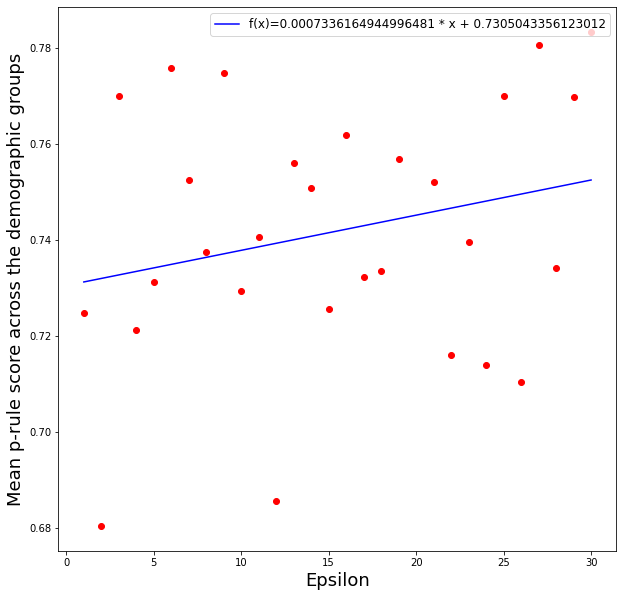

In [10]:
# PLOT OWN P-RULE MEAN

m, b = np.polyfit(epsilons, allpRuleOwnMeanArr, 1)

X2 = sm.add_constant(epsilons)
est = sm.OLS(allpRuleOwnMeanArr, X2)
est2 = est.fit()
print(est2.summary())

print(stats.pearsonr(epsilons, allpRuleOwnMeanArr))

plt.figure(figsize=(10,10))
plt.scatter(epsilons, allpRuleOwnMeanArr, color='r')
#plt.scatter(epsilons, epsValues)
plt.plot(epsilons, m*np.log(epsilons) + b, color='b', label='f(x)='+"{:.5f}".format(m)+' * ln(x) + '+ "{:.5f}".format(b))
#plt.plot(epsilons, 0*epsilons + pRuleOwnMean)
#plt.title("", fontsize=18)
plt.xlabel("Epsilon", fontsize=18)
plt.ylabel("Mean p-rule score across the demographic groups", fontsize=18)
plt.legend(loc="upper right", fontsize=12)
plt.savefig('5OwnMeanWilds1to30eps.png', bbox_inches='tight')
plt.show()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     3.233
Date:                Fri, 04 Jun 2021   Prob (F-statistic):             0.0834
Time:                        15:28:38   Log-Likelihood:                 61.921
No. Observations:                  29   AIC:                            -119.8
Df Residuals:                      27   BIC:                            -117.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5658      0.017     33.256      0.0

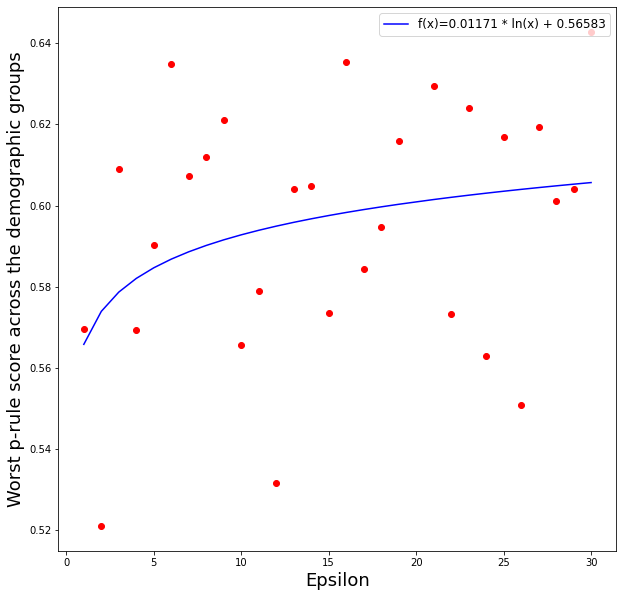

In [31]:
# PLOT OWN P-RULE MIN
m, b = np.polyfit(np.log(epsilons), allpRuleOwnMinArr, 1)

X2 = sm.add_constant(np.log(epsilons))
est = sm.OLS(allpRuleOwnMinArr, X2)
est2 = est.fit()
print(est2.summary())

plt.figure(figsize=(10,10))
plt.scatter(epsilons, allpRuleOwnMinArr, color='r')
plt.plot(epsilons, m*np.log(epsilons) + b, color='b', label='f(x)='+"{:.5f}".format(m)+' * ln(x) + '+ "{:.5f}".format(b))
#plt.plot(epsilons, 0*epsilons + pRuleOwnMin)
#plt.title("", fontsize=18)
plt.xlabel("Epsilon", fontsize=18)
plt.ylabel("Worst p-rule score across the demographic groups", fontsize=18)
plt.legend(loc="upper right", fontsize=12)
plt.savefig('15OwnMinWilds1to30eps.png', bbox_inches='tight')
plt.show()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.029
Method:                 Least Squares   F-statistic:                    0.2030
Date:                Fri, 04 Jun 2021   Prob (F-statistic):              0.656
Time:                        15:28:38   Log-Likelihood:                 59.047
No. Observations:                  29   AIC:                            -114.1
Df Residuals:                      27   BIC:                            -111.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6746      0.019     35.906      0.0

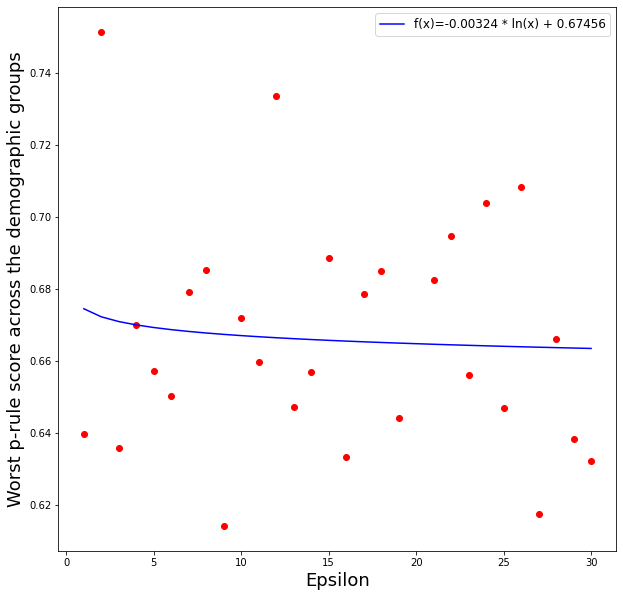

In [32]:
# PLOT OFFICIAL P-RULE MIN

m, b = np.polyfit(np.log(epsilons), allpRuleMinArr, 1)

X2 = sm.add_constant(np.log(epsilons))
est = sm.OLS(allpRuleMinArr, X2)
est2 = est.fit()
print(est2.summary())

plt.figure(figsize=(10,10))
plt.scatter(epsilons, allpRuleMinArr, color='r')
plt.plot(epsilons, m*np.log(epsilons) + b, color='b', label='f(x)='+"{:.5f}".format(m)+' * ln(x) + '+ "{:.5f}".format(b))
#plt.plot(epsilons, 0*epsilons + pRuleMin)
#plt.title("", fontsize=18)
plt.xlabel("Epsilon", fontsize=18)
plt.ylabel("Worst p-rule score across the demographic groups", fontsize=18)
plt.legend(loc="upper right", fontsize=12)
plt.savefig('15OfficialMinWilds1to30eps.png', bbox_inches='tight')
plt.show()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.9545
Date:                Fri, 04 Jun 2021   Prob (F-statistic):              0.337
Time:                        15:28:39   Log-Likelihood:                 65.704
No. Observations:                  29   AIC:                            -127.4
Df Residuals:                      27   BIC:                            -124.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8088      0.015     54.160      0.0

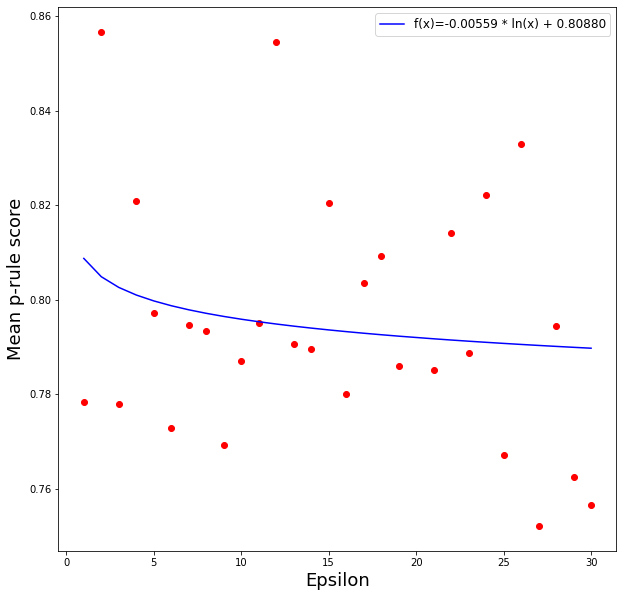

In [33]:
# PLOT OFFICIAL P-RULE Mean

m, b = np.polyfit(np.log(epsilons), allpRuleMeanArr, 1)

X2 = sm.add_constant(np.log(epsilons))
est = sm.OLS(allpRuleMeanArr, X2)
est2 = est.fit()
print(est2.summary())

plt.figure(figsize=(10,10))
plt.scatter(epsilons, allpRuleMeanArr, color='r')
plt.plot(epsilons, m*np.log(epsilons) + b, color='b', label='f(x)='+"{:.5f}".format(m)+' * ln(x) + '+ "{:.5f}".format(b))
#plt.plot(epsilons, 0*epsilons + pRuleMean)
#plt.title("", fontsize=18)
plt.xlabel("Epsilon", fontsize=18)
plt.ylabel("Mean p-rule score", fontsize=18)
plt.legend(loc="upper right", fontsize=12)
plt.savefig('15OfficialMeanWilds1to30eps.png', bbox_inches='tight')
plt.show()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     4.905
Date:                Fri, 04 Jun 2021   Prob (F-statistic):             0.0354
Time:                        15:28:39   Log-Likelihood:                 188.60
No. Observations:                  29   AIC:                            -373.2
Df Residuals:                      27   BIC:                            -370.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.000     11.590      0.0

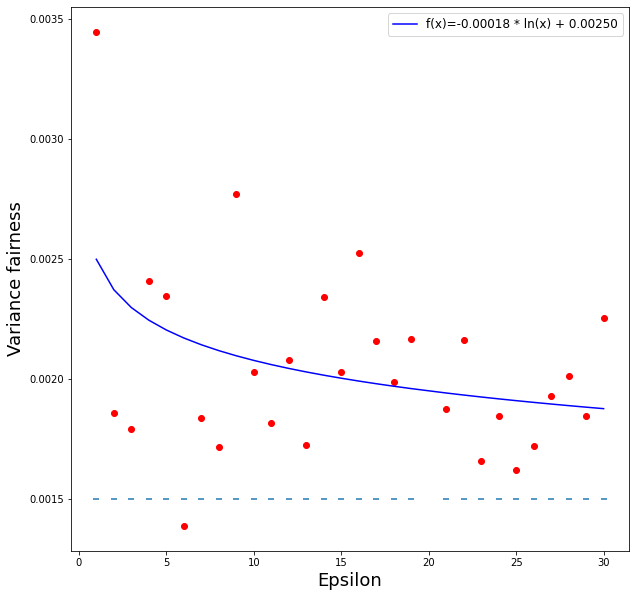

In [34]:
m, b = np.polyfit(np.log(epsilons), allvarF1, 1)

X2 = sm.add_constant(np.log(epsilons))
est = sm.OLS(allvarF1, X2)
est2 = est.fit()
print(est2.summary())

plt.figure(figsize=(10,10))
plt.scatter(epsilons, allvarF1, color='r')
plt.scatter(epsilons, np.multiply(len(epsilons)*[1.0], 0.0015), marker = '_')
plt.plot(epsilons, m*np.log(epsilons) + b, color='b', label='f(x)='+"{:.5f}".format(m)+' * ln(x) + '+ "{:.5f}".format(b))
#plt.title("Fairness", fontsize=18)
plt.xlabel("Epsilon", fontsize=18)
plt.ylabel("Variance fairness", fontsize=18)
plt.legend(loc="upper right", fontsize=12)
plt.savefig('15varf1Wilds1to30eps.png', bbox_inches='tight')
plt.show()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     4.905
Date:                Fri, 04 Jun 2021   Prob (F-statistic):             0.0354
Time:                        15:28:39   Log-Likelihood:                 188.60
No. Observations:                  29   AIC:                            -373.2
Df Residuals:                      27   BIC:                            -370.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.000     11.590      0.0

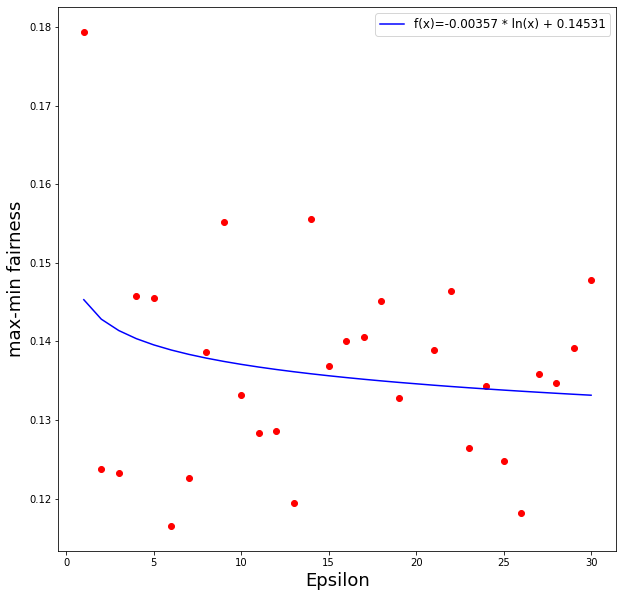

In [35]:
X2 = sm.add_constant(np.log(epsilons))
est = sm.OLS(allvarF1, X2)
est2 = est.fit()
print(est2.summary())

m, b = np.polyfit(np.log(epsilons), allminMaxF1, 1)
plt.figure(figsize=(10,10))
plt.scatter(epsilons, allminMaxF1, color='r')
plt.plot(epsilons, m*np.log(epsilons) + b, color='b', label='f(x)='+"{:.5f}".format(m)+' * ln(x) + '+ "{:.5f}".format(b))
plt.xlabel("Epsilon", fontsize=18)
plt.ylabel("max-min fairness", fontsize=18)
plt.legend(loc="upper right", fontsize=12)
plt.savefig('15minmaxf1Wilds1to30eps.png', bbox_inches='tight')
plt.show()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.125
Method:                 Least Squares   F-statistic:                     4.988
Date:                Fri, 04 Jun 2021   Prob (F-statistic):             0.0340
Time:                        15:28:40   Log-Likelihood:                 88.343
No. Observations:                  29   AIC:                            -172.7
Df Residuals:                      27   BIC:                            -170.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6611      0.007     96.641      0.0

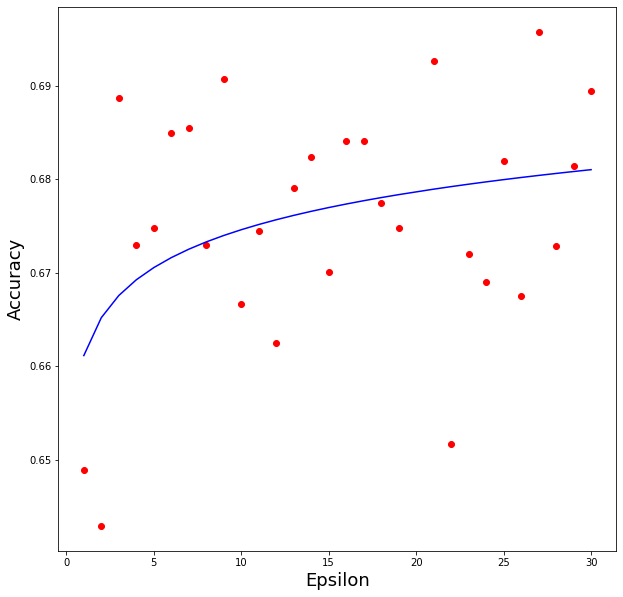

In [36]:
X2 = sm.add_constant(np.log(epsilons))
est = sm.OLS(allaccuracy, X2)
est2 = est.fit()
print(est2.summary())

m, b = np.polyfit(np.log(epsilons), allaccuracy, 1)

plt.figure(figsize=(10,10))
plt.scatter(epsilons, allaccuracy, color='r')
plt.plot(epsilons, m*np.log(epsilons) + b, color='b', label='f(x)='+"{:.5f}".format(m)+' * ln(x) + '+ "{:.5f}".format(b))


plt.xlabel("Epsilon", fontsize=18)
plt.ylabel("Accuracy", fontsize=18)
plt.savefig('15accuracyWilds1to30eps.png', bbox_inches='tight')
plt.show()

In [17]:
# Checking no privacy model
varF1 = []
minMaxF1 = []
pRuleOwnMeanArr = []
pRuleOwnMinArr = []
pRuleMeanArr = []
pRuleMinArr = []
accuracy = []
for i in range(1,11):
    test_preds, val_preds = loadTestAndValPreds(i, 'finalOwnWilds/logs/50000noDP/civilcomments_split-')
    temp_df = pd.concat([test_preds, df], axis=1)
    f1_scores, accuracies = F1AndAcc(temp_df)

    own = pRuleOwn(temp_df)       
    pRuleOwnMinArr.append(np.min(own))
    pRuleOwnMeanArr.append(np.mean(own))

    official = pRule(temp_df)
    pRuleMinArr.append(np.min(official))
    pRuleMeanArr.append(np.mean(official))

    #F1 Variance
    varF1.append(VarianceFairness(f1_scores))

    #F1 Min Max
    minMaxF1.append(MinMaxFairness(f1_scores))

    labels = np.array(temp_df['toxicity'].values.tolist())
    preds = np.array(temp_df['test predictions'].values.tolist())
    accuracy.append(CheckAccuracy(preds,labels))

FileNotFoundError: [Errno 2] No such file or directory: 'finalOwnWilds/logs/50000noDP/civilcomments_split-test_seed-1_epoch-best_pred.csv'

In [ ]:
print(f'varF1:\t\t {np.mean(varF1):.4f}')
print(f'minMaxF1:\t {np.mean(minMaxF1):.4f}')
print(f'pRuleOwnMeanArr: {np.mean(pRuleOwnMeanArr):.4f}')
print(f'pRuleOwnMinArr:\t {np.mean(pRuleOwnMinArr):.4f}')
print(f'pRuleMeanArr:\t {np.mean(pRuleMeanArr):.4f}')
print(f'pRuleMinArr:\t {np.mean(pRuleMinArr):.4f}')
print(f'Avg accuracy:\t {np.mean(accuracy):.4f}')